## Data Wrangling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import geopandas as gpd

import plotly.express as px
import plotly.graph_objects as go

sns.set()

## Load Data

In [2]:
# The supplied CSV data file is the DataSet directory
weather_df = pd.read_csv('../data/weather.csv')
spray_df = pd.read_csv('../data/spray.csv')
train_df = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

## Check Data

### Train, Test Data

These test results are organized in such a way that when the number of mosquitos exceed 50, they are split into another record (another row in the dataset), such that the number of mosquitos are capped at 50. 

The location of the traps are described by the block number and street name. For your convenience, we have mapped these attributes into Longitude and Latitude in the dataset. Please note that these are derived locations. For example, Block=79, and Street= "W FOSTER AVE" gives us an approximate address of "7900 W FOSTER AVE, Chicago, IL", which translates to (41.974089,-87.824812) on the map.

Some traps are "satellite traps". These are traps that are set up near (usually within 6 blocks) an established trap to enhance surveillance efforts. Satellite traps are postfixed with letters. For example, T220A is a satellite trap to T220. 

Please note that not all the locations are tested at all times. Also, records exist only when a particular species of mosquitos is found at a certain trap at a certain time. In the test set, we ask you for all combinations/permutations of possible predictions and are only scoring the observed ones.

In [3]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Id                      116293 non-null  int64  
 1   Date                    116293 non-null  object 
 2   Address                 116293 non-null  object 
 3   Species                 116293 non-null  object 
 4   Block                   116293 non-null  int64  
 5   Street                  116293 non-null  object 
 6   Trap                    116293 non-null  object 
 7   AddressNumberAndStreet  116293 non-null  object 
 8   Latitude                116293 non-null  float64
 9   Longitude               116293 non-null  float64
 10  AddressAccuracy         116293 non-null  int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 9.8+ MB


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    10506 non-null  object 
 1   Address                 10506 non-null  object 
 2   Species                 10506 non-null  object 
 3   Block                   10506 non-null  int64  
 4   Street                  10506 non-null  object 
 5   Trap                    10506 non-null  object 
 6   AddressNumberAndStreet  10506 non-null  object 
 7   Latitude                10506 non-null  float64
 8   Longitude               10506 non-null  float64
 9   AddressAccuracy         10506 non-null  int64  
 10  NumMosquitos            10506 non-null  int64  
 11  WnvPresent              10506 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 985.1+ KB


In [5]:
train_df.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


### Weather Data

It is believed that hot and dry conditions are more favorable for West Nile virus than cold and wet. We provide you with the dataset from NOAA of the weather conditions of 2007 to 2014, during the months of the tests. 

Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level \
Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

In [6]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   object 
 5   Depart       2944 non-null   object 
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2944 non-null   object 
 8   Heat         2944 non-null   object 
 9   Cool         2944 non-null   object 
 10  Sunrise      2944 non-null   object 
 11  Sunset       2944 non-null   object 
 12  CodeSum      2944 non-null   object 
 13  Depth        2944 non-null   object 
 14  Water1       2944 non-null   object 
 15  SnowFall     2944 non-null   object 
 16  PrecipTotal  2944 non-null   object 
 17  StnPressure  2944 non-null   object 
 18  SeaLevel     2944 non-null   object 
 19  Result

In [7]:
weather_df.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [8]:
# Get Station data into ohare and midway dictionary
keys = ['Latitude','Longitude', 'SeaLevel']

ohare_val = [41.995, -87.933, 662]
midway_val = [41.786, -87.752, 612]

Station1 = dict(zip(keys, ohare_val))
Station2 = dict(zip(keys, midway_val))

### Spray Data

The City of Chicago also does spraying to kill mosquitos. You are given the GIS data for their spray efforts in 2011 and 2013. Spraying can reduce the number of mosquitos in the area, and therefore might eliminate the appearance of West Nile virus. 

In [9]:
spray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       14835 non-null  object 
 1   Time       14251 non-null  object 
 2   Latitude   14835 non-null  float64
 3   Longitude  14835 non-null  float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB


In [10]:
spray_df.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


### Clean Train Data

In [11]:
## Drop all irrelevant columns
#train_df.drop(columns = ['Address','AddressNumberAndStreet'], inplace = True)
#train_df.head()

In [12]:
train_df.describe()

,Block,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
count,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000
mean,35.687797,41.841139,-87.699908,7.819532,12.853512,0.052446
std,24.339468,0.112742,0.096514,1.452921,16.133816,0.222936
min,10.000000,41.644612,-87.930995,3.000000,1.000000,0.000000
25%,12.000000,41.732984,-87.760070,8.000000,2.000000,0.000000
50%,33.000000,41.846283,-87.694991,8.000000,5.000000,0.000000
75%,52.000000,41.954690,-87.627796,9.000000,17.000000,0.000000
max,98.000000,42.017430,-87.531635,9.000000,50.000000,1.000000


In [13]:
train_df['Date'] = train_df['Date'].apply(pd.to_datetime)

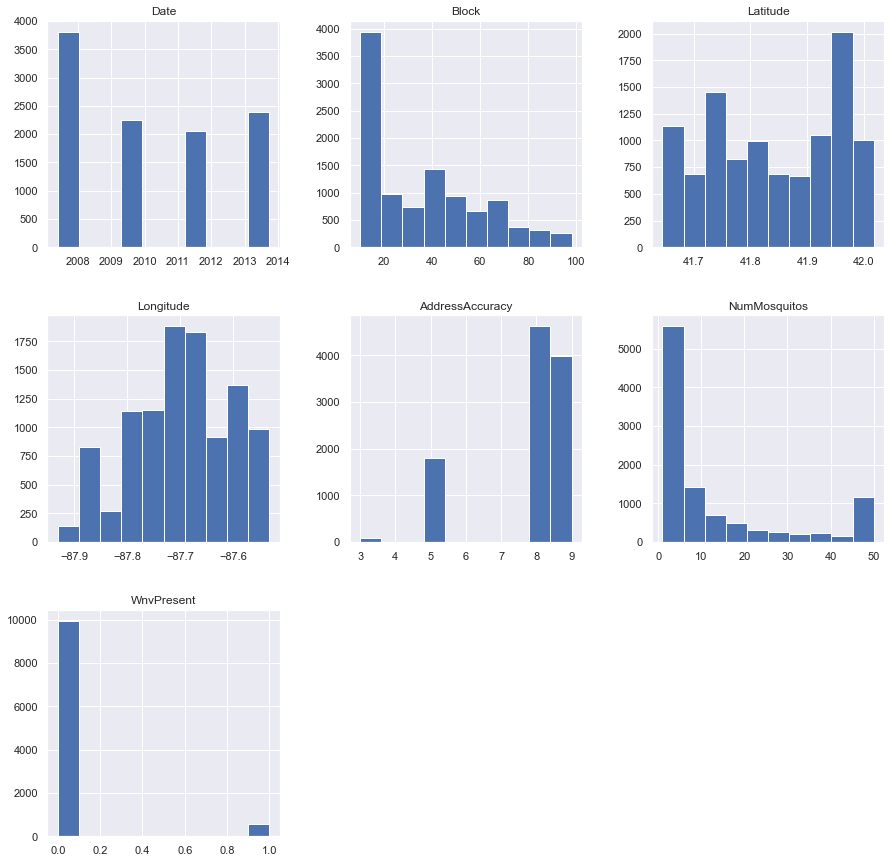

In [14]:
train_df.hist(figsize=(15, 15))
plt.show()

### Clean Weather Data

In [15]:
# Will ignore station two data for the first try. Will try to come back later
#weather_df1 = weather_df.loc[weather_df['Station']==1]
#weather_df1 = weather_df
weather_df.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [16]:
weather_df.reset_index(drop = True)

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2939,2,2014-10-29,49,40,45,M,34,42,20,0,...,,M,M,M,0.00,29.42,30.07,8.5,29,9.0
2940,1,2014-10-30,51,32,42,-4,34,40,23,0,...,,0,M,0.0,0.00,29.34,30.09,5.1,24,5.5
2941,2,2014-10-30,53,37,45,M,35,42,20,0,...,RA,M,M,M,T,29.41,30.10,5.9,23,6.5
2942,1,2014-10-31,47,33,40,-6,25,33,25,0,...,RA SN,0,M,0.1,0.03,29.49,30.20,22.6,34,22.9


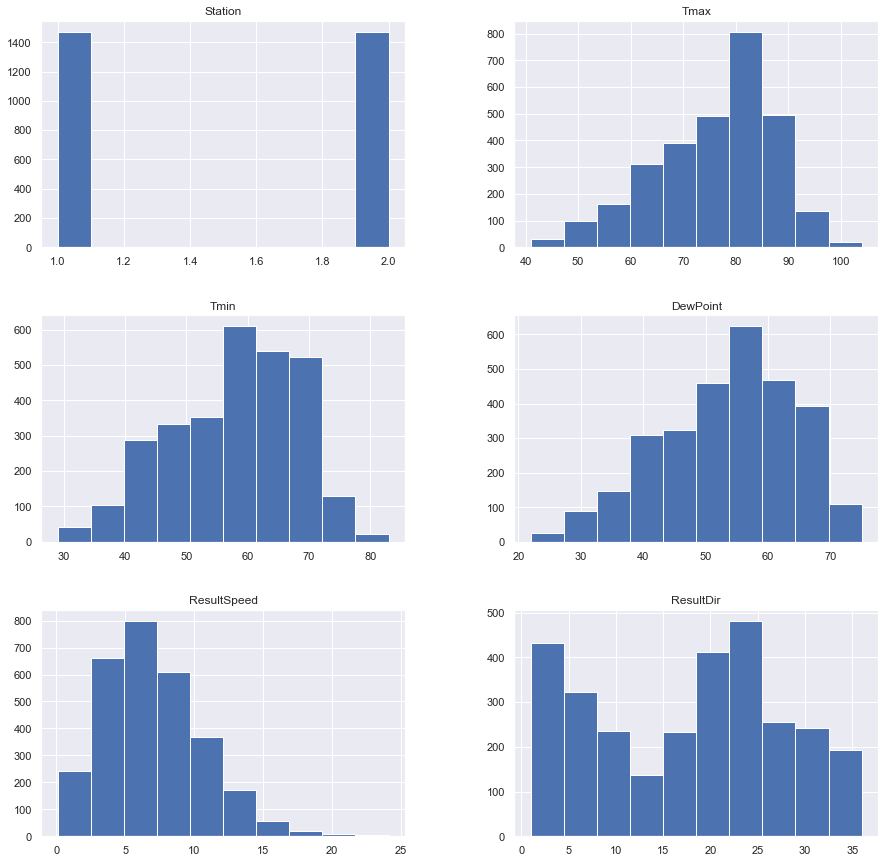

In [17]:
weather_df.hist(figsize=(15, 15))
plt.show()

In [18]:
#Change date column to datetime
weather_df['Date'] = weather_df['Date'].apply(pd.to_datetime)

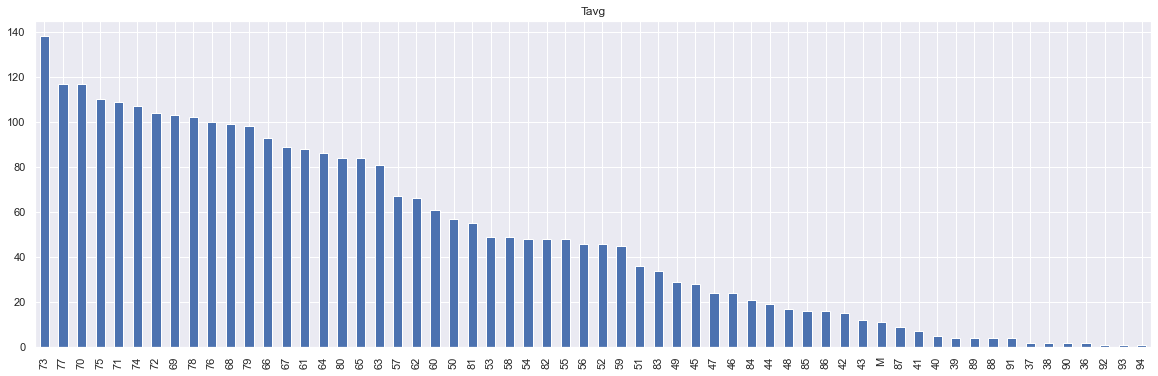

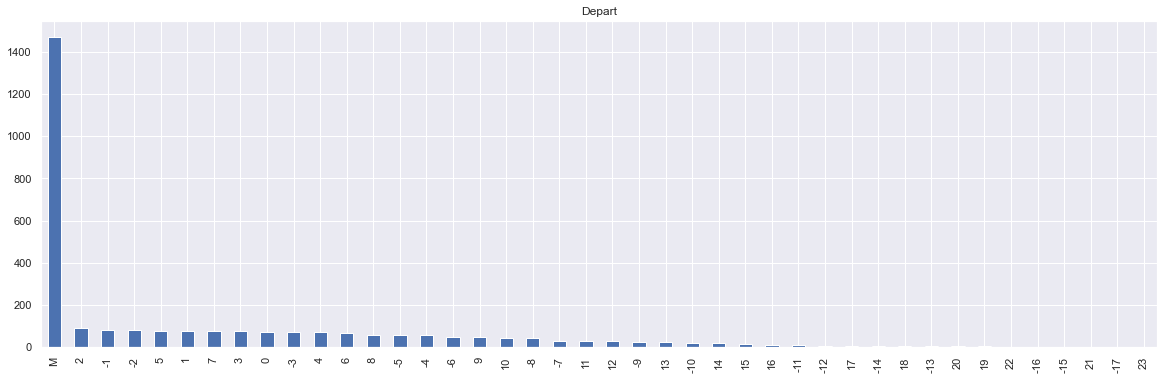

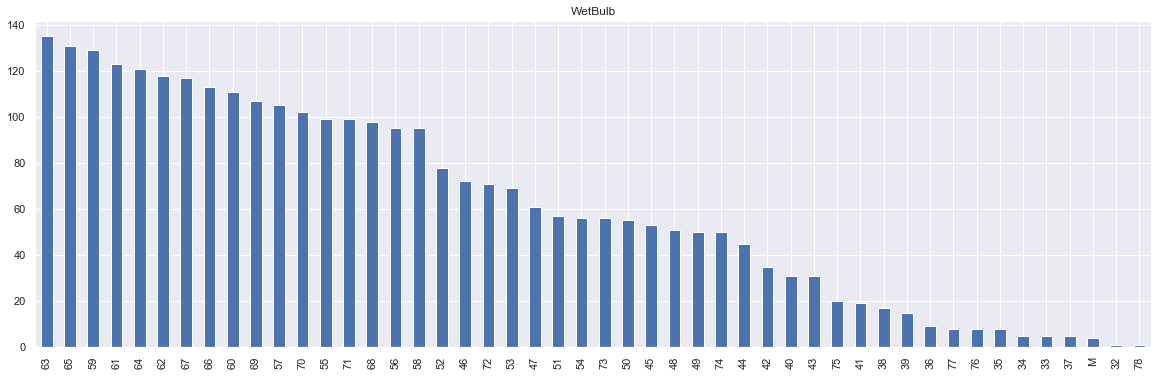

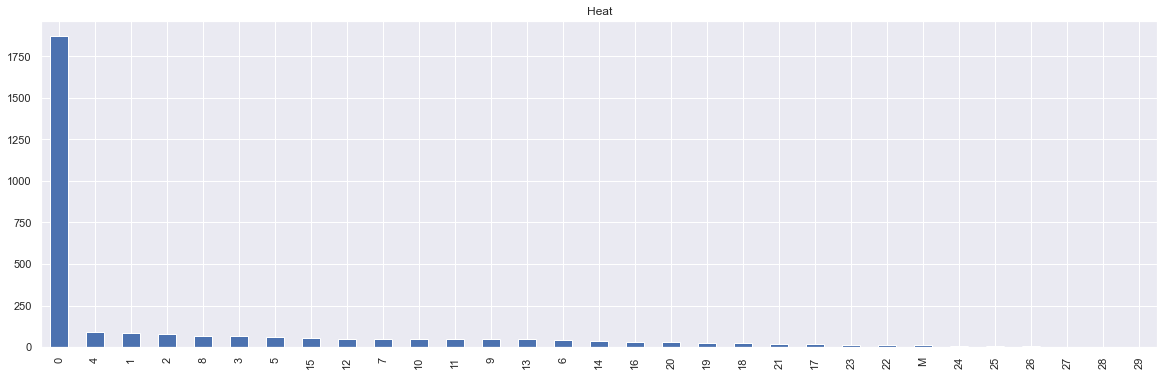

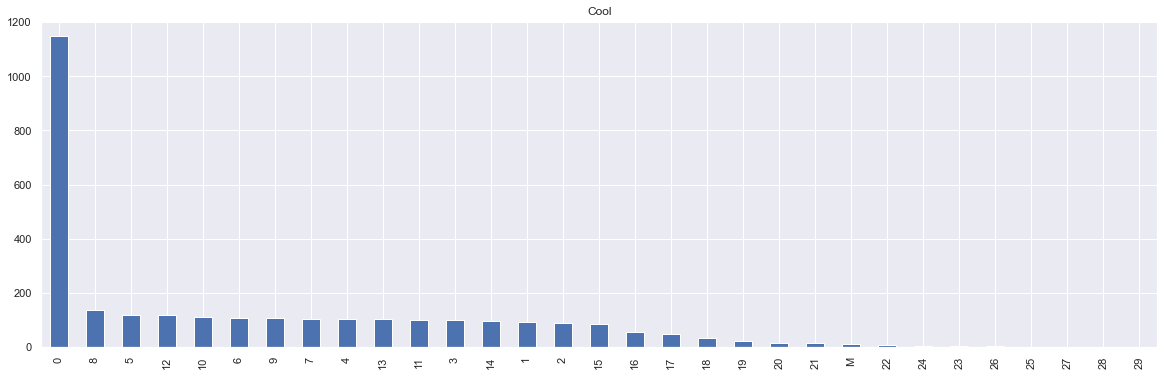

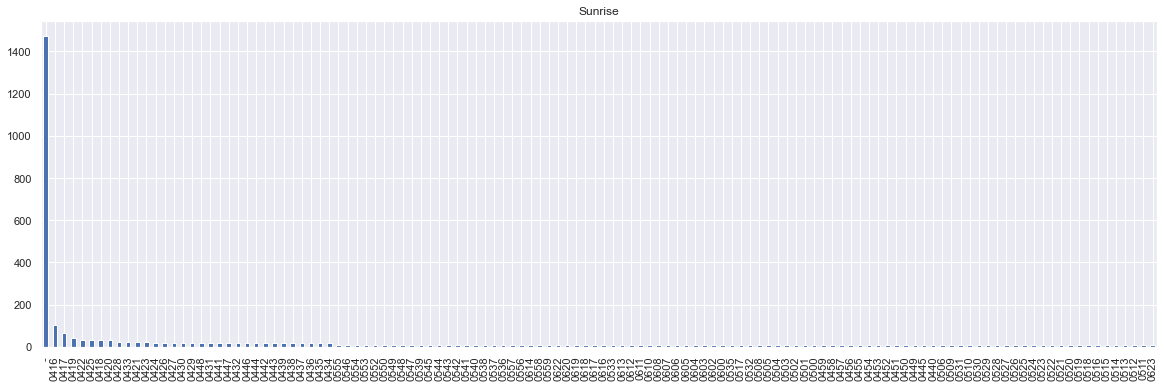

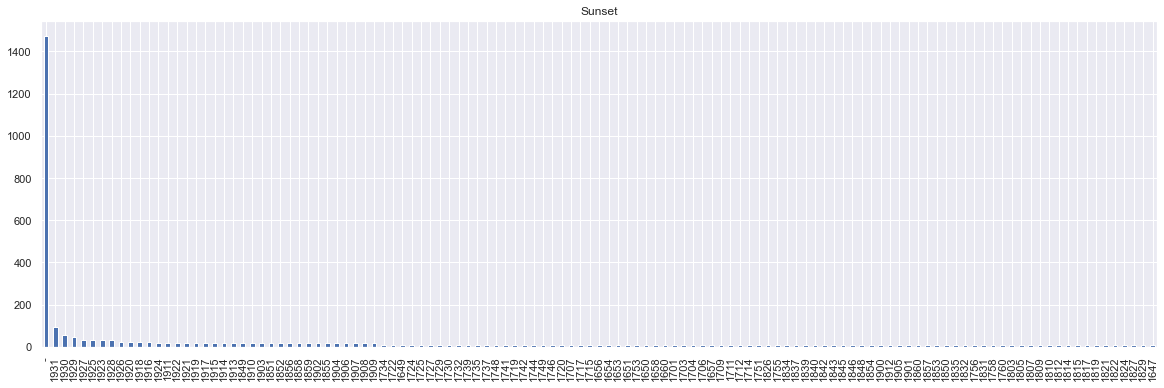

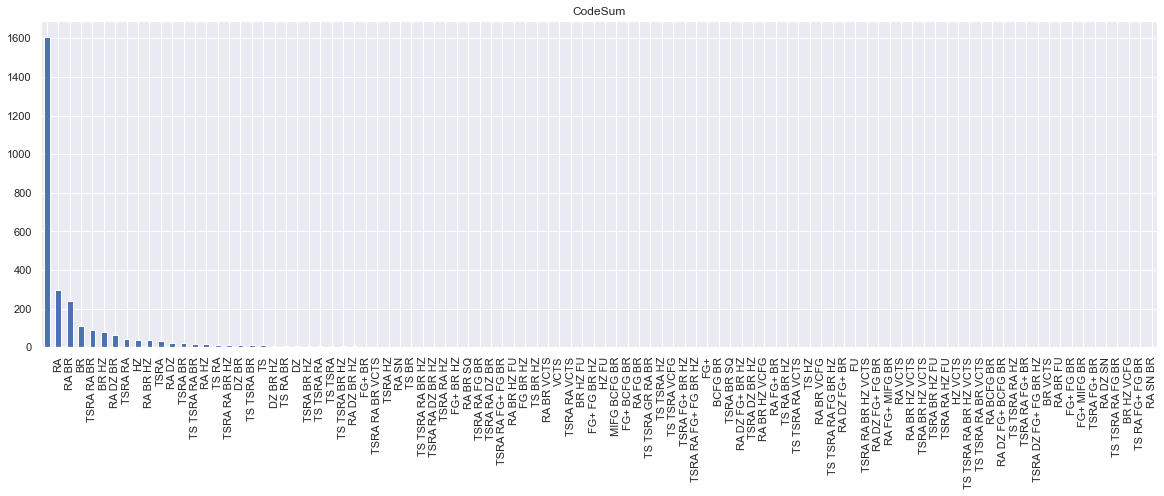

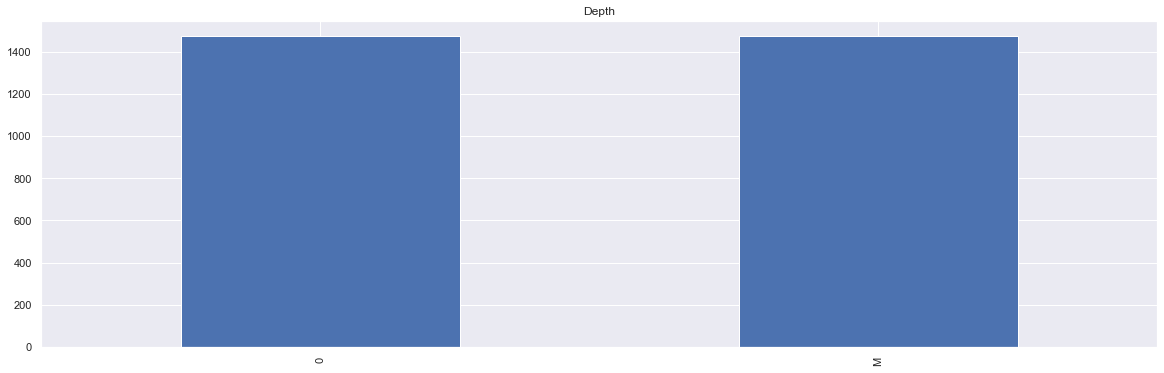

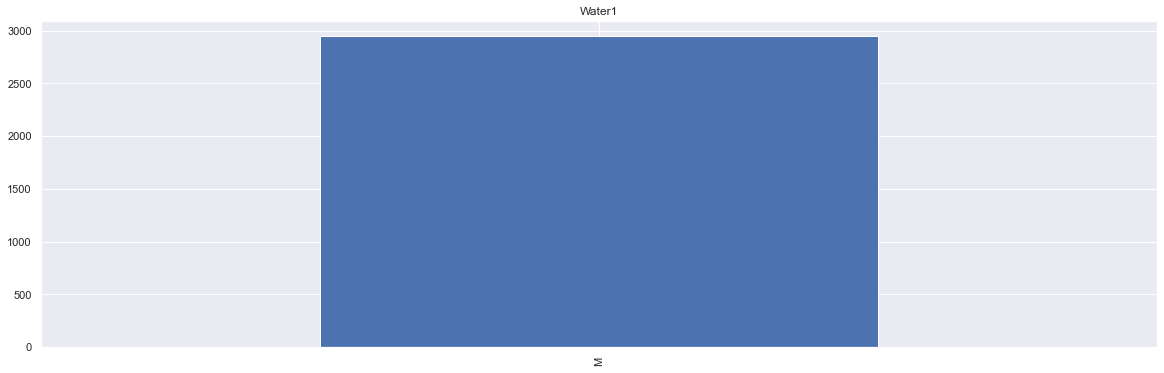

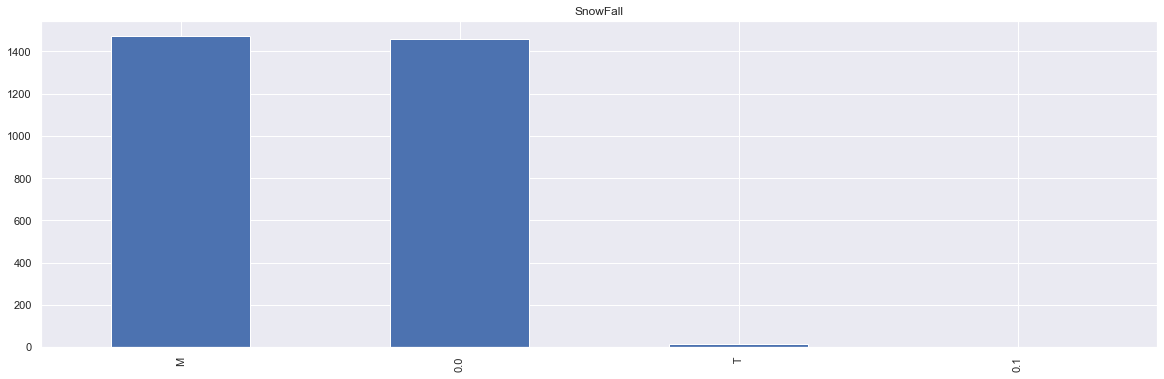

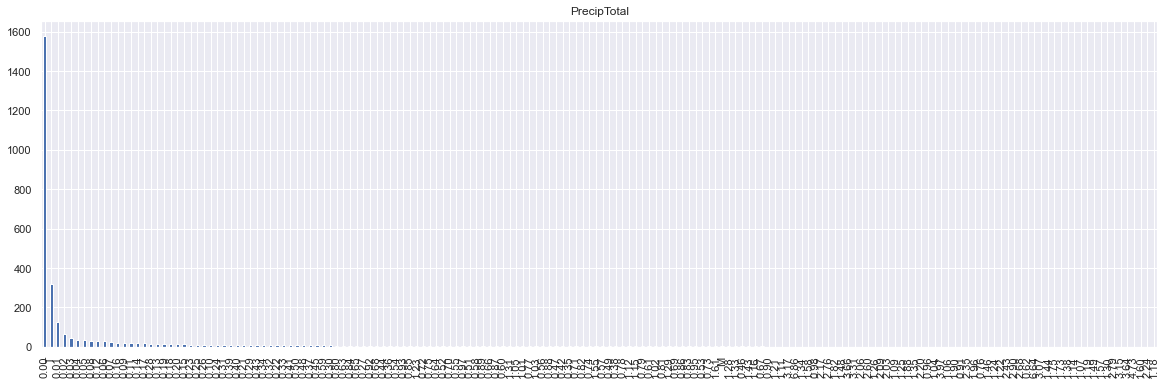

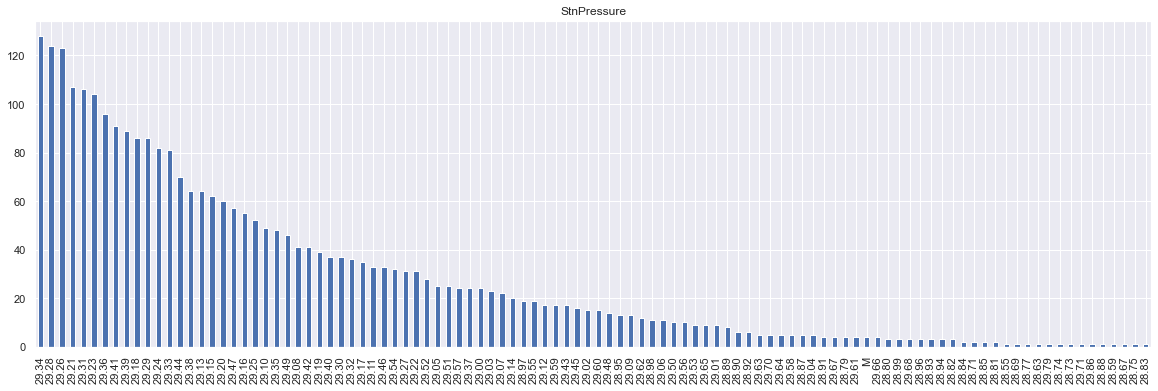

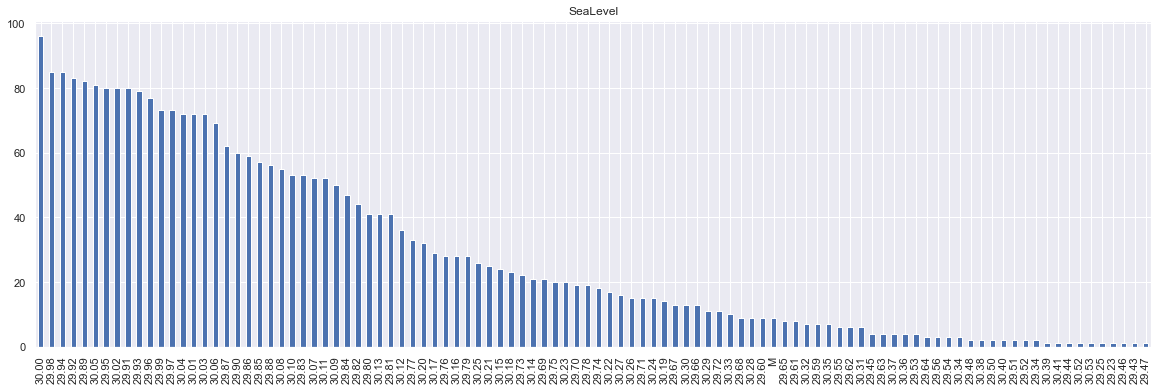

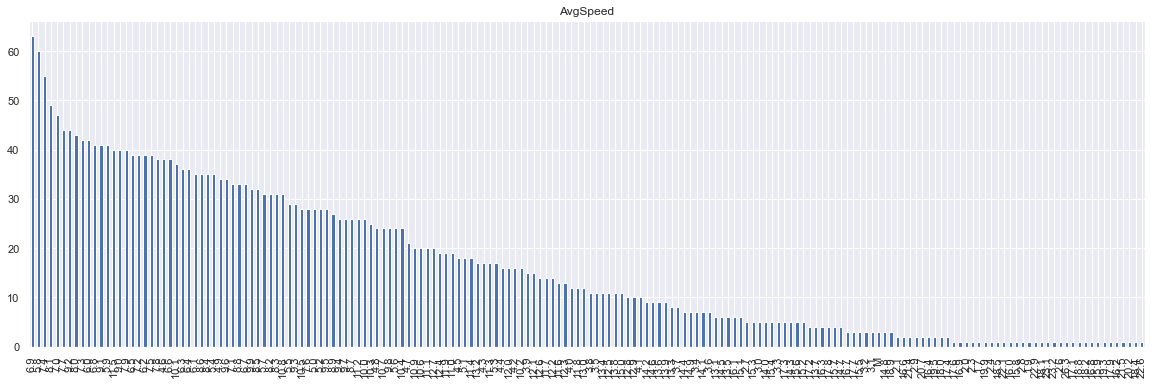

In [19]:
# lets insepct all non-numeric columns using value counts
for each_cols in weather_df.columns[weather_df.dtypes.eq('object')]:
    plt.figure(figsize = (20,6))
    weather_df[each_cols].value_counts().plot(kind = 'bar')
    plt.title(each_cols)

In [20]:
# Inspect suspicious looking column

# Depart, Sunrise, Sunset, CodeSum, Depth, Water1, Snowfall, PrecipTotal

In [21]:
# Depart
print(weather_df['Depart'].value_counts())

M      1472
 2       93
-1       84
-2       80
 5       77
 1       76
 7       76
 3       75
 0       74
-3       72
 4       71
 6       67
 8       59
-5       57
-4       56
-6       50
 9       47
10       46
-8       43
-7       30
11       28
12       28
-9       25
13       23
-10      22
14       22
15       15
16       12
-11      10
-12       8
17        7
-14       6
18        6
-13       5
20        4
19        4
22        3
-16       3
-15       3
21        2
-17       2
23        1
Name: Depart, dtype: int64


In [22]:
# Since half the data is missing and is not trivial to calculate depart without knowing the normal temp, lets drop this
weather_df.drop(columns = ['Depart'], inplace = True)

In [23]:
# For sunrise and sunset the data from station 2 is misisng but there is data from station 1 for the corrresponding
# date. Since both airports are close by lets replace misisng values from station 1 for the same date.
for index, row in weather_df.iterrows():
    if (row['Sunrise'])!='-': # values not missing - 'nan' is type float; otherwise it would be type str
        previous_sunrise = row['Sunrise'] # store for the next record
        previous_sunset = row['Sunset'] # store for the next record
    else:
        weather_df.loc[index,'Sunrise'] = previous_sunrise
        weather_df.loc[index,'Sunset'] = previous_sunset

In [24]:
# CodeSum
print(weather_df['CodeSum'].value_counts())

                    1609
RA                   296
RA BR                238
BR                   110
TSRA RA BR            92
                    ... 
RA DZ SN               1
TS TSRA RA FG BR       1
BR HZ VCFG             1
TS RA FG+ FG BR        1
RA SN BR               1
Name: CodeSum, Length: 98, dtype: int64


In [25]:
# More than half the values are missing and the rest are also not terribly informative so drop it
weather_df.drop(columns = ['CodeSum'], inplace = True)

In [26]:
print(weather_df['Depth'].value_counts())

0    1472
M    1472
Name: Depth, dtype: int64


In [27]:
# Half the values are missing and other halfs are 0 so drop this one as well
weather_df.drop(columns = ['Depth'], inplace = True)

In [28]:
print(weather_df['Water1'].value_counts())

M    2944
Name: Water1, dtype: int64


In [29]:
# All values are misisng so drop this one as well
weather_df.drop(columns = ['Water1'], inplace = True)

In [30]:
print(weather_df['SnowFall'].value_counts())

M      1472
0.0    1459
  T      12
0.1       1
Name: SnowFall, dtype: int64


In [31]:
# Looks like half is missing (one weather station). Lets leave M as it is because we will convert all M to nan later so convert them to nan and convert T (trace to some small value)
# Let's convert T = Trace to some smaller value, let's say T = 0.001

weather_df['SnowFall'].replace('  T', '0.001', inplace = True) # left as string because rest of the values are string

In [32]:
print(weather_df['SnowFall'].value_counts())

M        1472
0.0      1459
0.001      12
0.1         1
Name: SnowFall, dtype: int64


In [33]:
#PrecipTotal
print(weather_df['PrecipTotal'].value_counts())

0.00    1577
  T      318
0.01     127
0.02      63
0.03      46
        ... 
3.64       1
4.73       1
1.60       1
2.24       1
1.18       1
Name: PrecipTotal, Length: 168, dtype: int64


In [34]:
# Let's replace T = Trace in precipTotal with small value as well T = 0.001
weather_df['PrecipTotal'].replace('  T', '0.001', inplace = True)
print(weather_df['PrecipTotal'].value_counts())

0.00     1577
0.001     318
0.01      127
0.02       63
0.03       46
         ... 
3.64        1
4.73        1
1.60        1
2.24        1
1.18        1
Name: PrecipTotal, Length: 168, dtype: int64


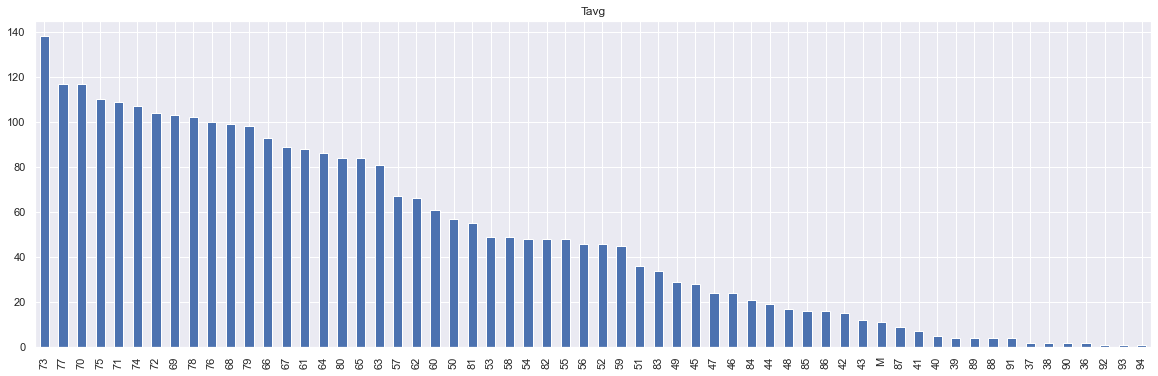

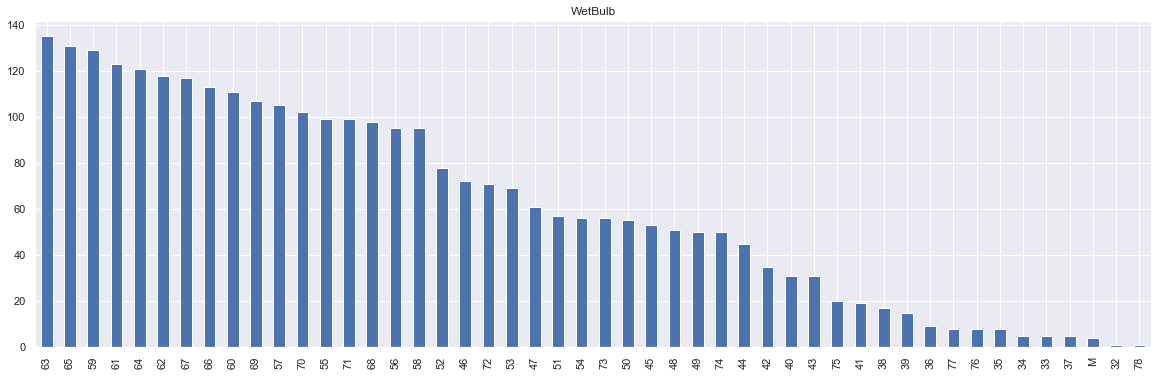

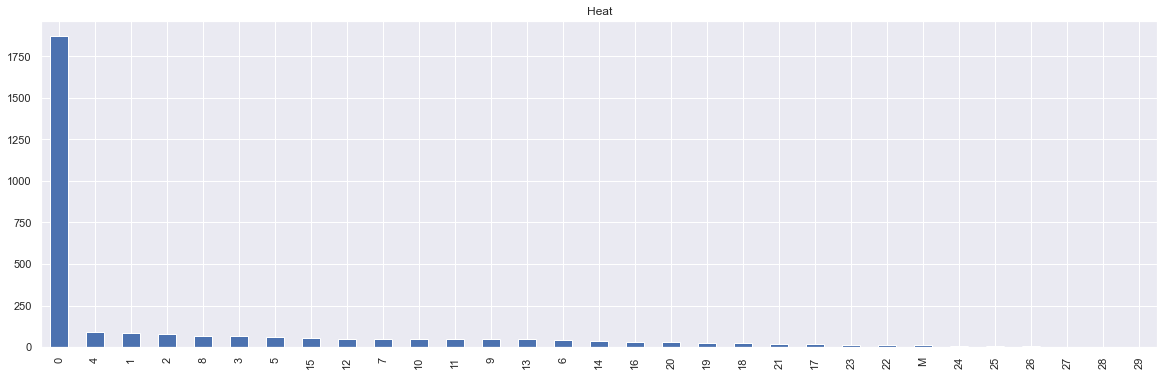

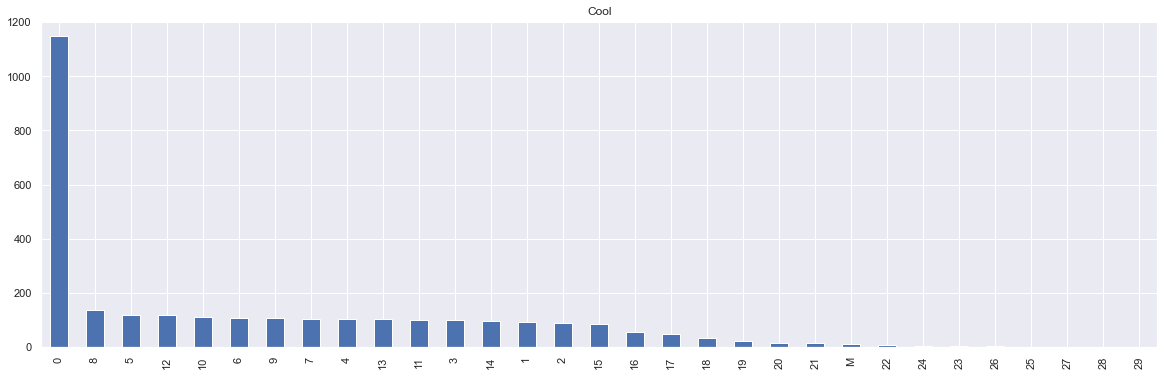

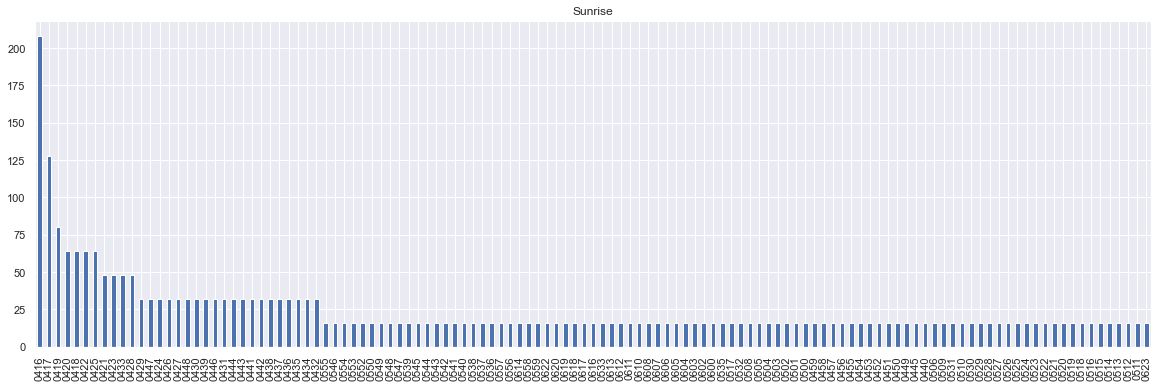

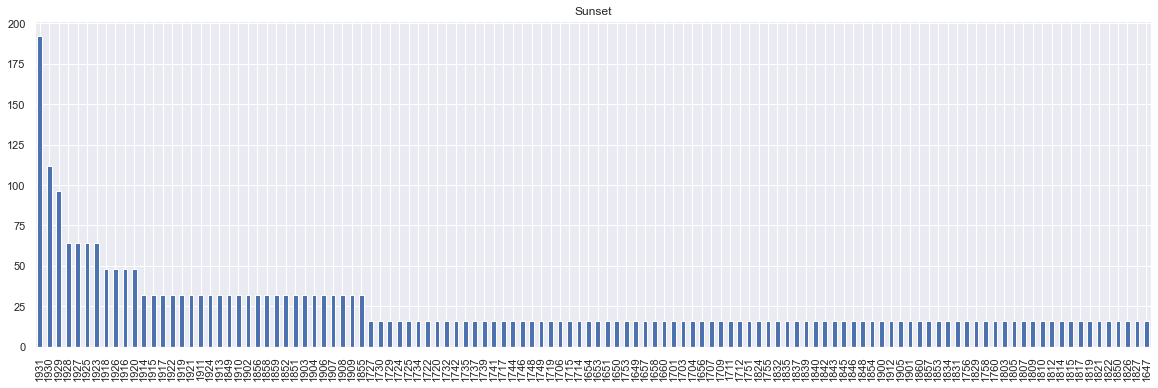

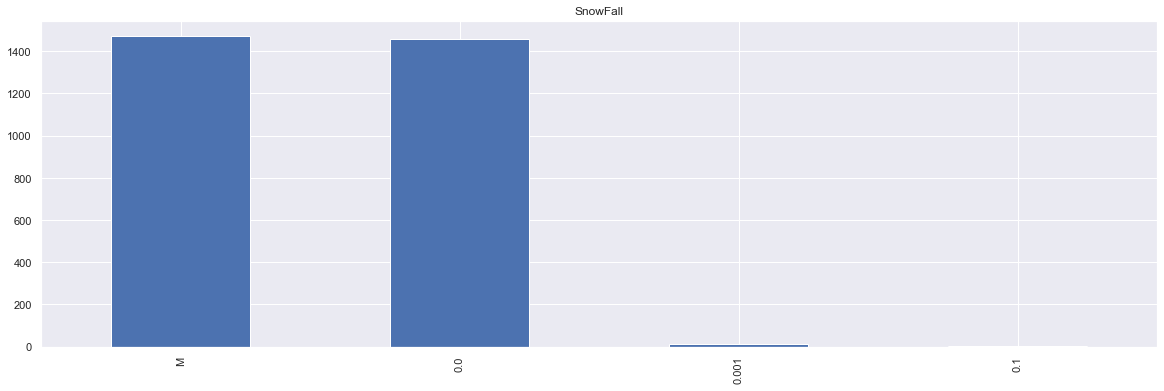

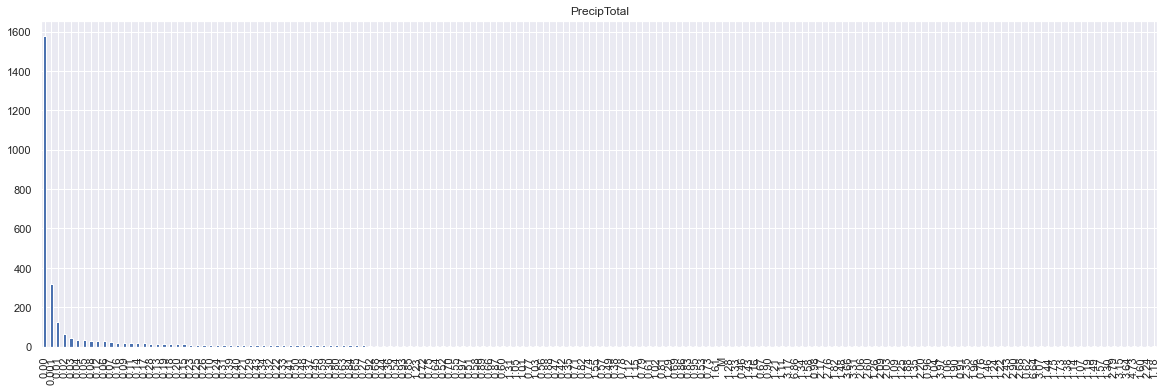

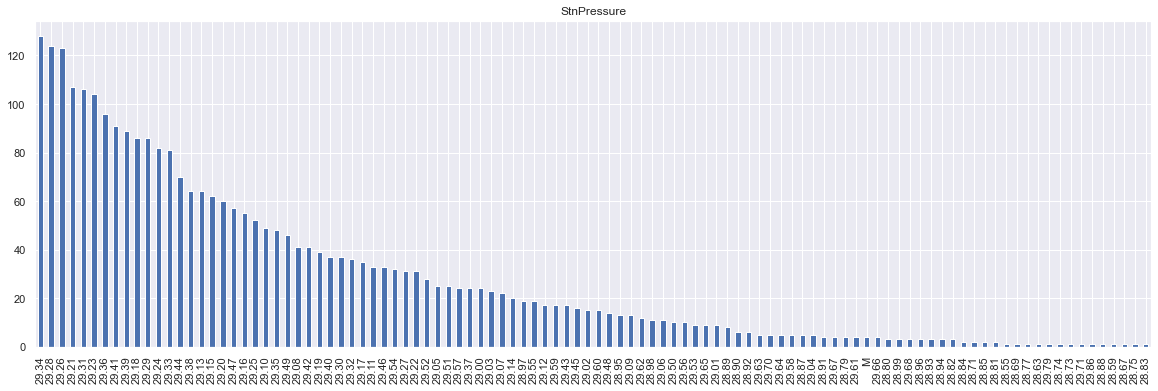

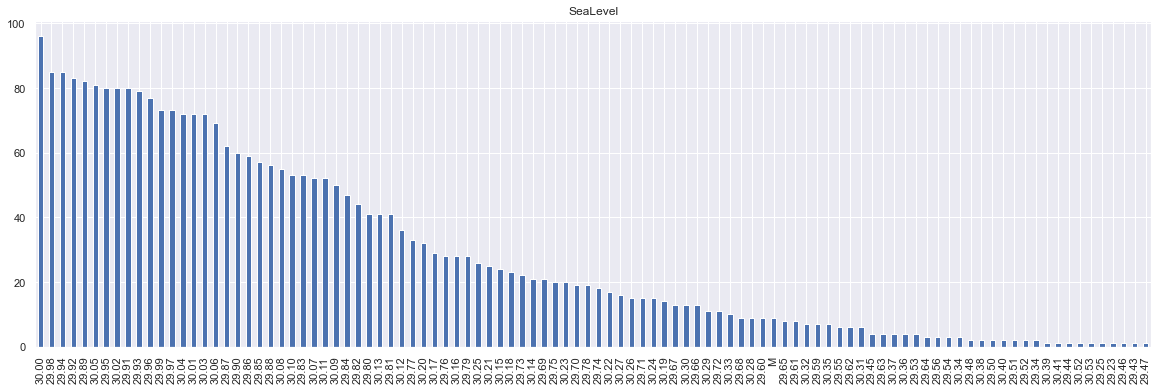

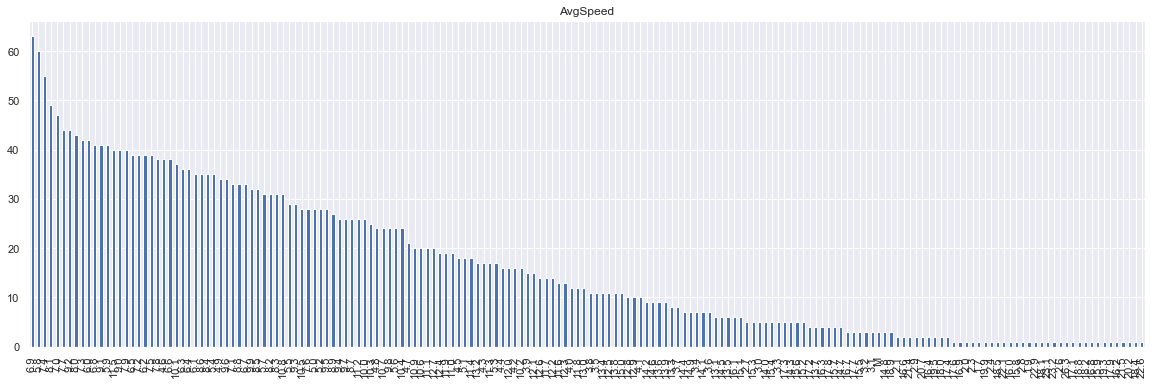

In [35]:
# Let's reinspect
for each_cols in weather_df.columns[weather_df.dtypes.eq('object')]:
    plt.figure(figsize = (20,6))
    weather_df[each_cols].value_counts().plot(kind = 'bar')
    plt.title(each_cols)

In [36]:
# # It is looking much cleaner. Let's Convert all object columns to numeric
# This will also force all 'M' to nan

cols = weather_df.columns[weather_df.dtypes.eq('object')]

weather_df[cols] = weather_df[cols].apply(pd.to_numeric, errors='coerce')
weather_df.head()

,Station,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67.0,51,56.0,0.0,2.0,448,1849,0.0,0.0,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68.0,51,57.0,0.0,3.0,448,1849,NaN,0.0,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51.0,42,47.0,14.0,0.0,447,1850,0.0,0.0,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52.0,42,47.0,13.0,0.0,447,1850,NaN,0.0,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56.0,40,48.0,9.0,0.0,446,1851,0.0,0.0,29.39,30.12,11.7,7,11.9


In [37]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   int64         
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   int64         
 3   Tmin         2944 non-null   int64         
 4   Tavg         2933 non-null   float64       
 5   DewPoint     2944 non-null   int64         
 6   WetBulb      2940 non-null   float64       
 7   Heat         2933 non-null   float64       
 8   Cool         2933 non-null   float64       
 9   Sunrise      2944 non-null   int64         
 10  Sunset       2944 non-null   int64         
 11  SnowFall     1472 non-null   float64       
 12  PrecipTotal  2942 non-null   float64       
 13  StnPressure  2940 non-null   float64       
 14  SeaLevel     2935 non-null   float64       
 15  ResultSpeed  2944 non-null   float64       
 16  Result

In [38]:
# Checking if there are null values
weather_df.isnull().sum()

Station           0
Date              0
Tmax              0
Tmin              0
Tavg             11
DewPoint          0
WetBulb           4
Heat             11
Cool             11
Sunrise           0
Sunset            0
SnowFall       1472
PrecipTotal       2
StnPressure       4
SeaLevel          9
ResultSpeed       0
ResultDir         0
AvgSpeed          3
dtype: int64

In [39]:
# Still don't know what to do with Snowfall. I have a feeling this info is baked on PrecipTotal so I will drop it
weather_df.drop(columns = ['SnowFall'], inplace = True)
weather_df.isnull().sum()

Station         0
Date            0
Tmax            0
Tmin            0
Tavg           11
DewPoint        0
WetBulb         4
Heat           11
Cool           11
Sunrise         0
Sunset          0
PrecipTotal     2
StnPressure     4
SeaLevel        9
ResultSpeed     0
ResultDir       0
AvgSpeed        3
dtype: int64

In [40]:
# Missing Tavg can be polulated using Tmax and Tmin
for index, row in weather_df.iterrows():
    if np.isnan(row['Tavg']):
        weather_df.loc[index,'Tavg'] = (row['Tmax']+row['Tmin'])/2
        
weather_df['Tavg'].isnull().sum()

0

In [41]:
# Replace rest of the NaN with median values
re_cols = weather_df.columns[weather_df.isnull().sum() !=0]

for each_col in re_cols:
    weather_df[each_col].fillna(weather_df[each_col].median(), inplace=True)

# Check if any null left 
weather_df.isnull().sum()

Station        0
Date           0
Tmax           0
Tmin           0
Tavg           0
DewPoint       0
WetBulb        0
Heat           0
Cool           0
Sunrise        0
Sunset         0
PrecipTotal    0
StnPressure    0
SeaLevel       0
ResultSpeed    0
ResultDir      0
AvgSpeed       0
dtype: int64

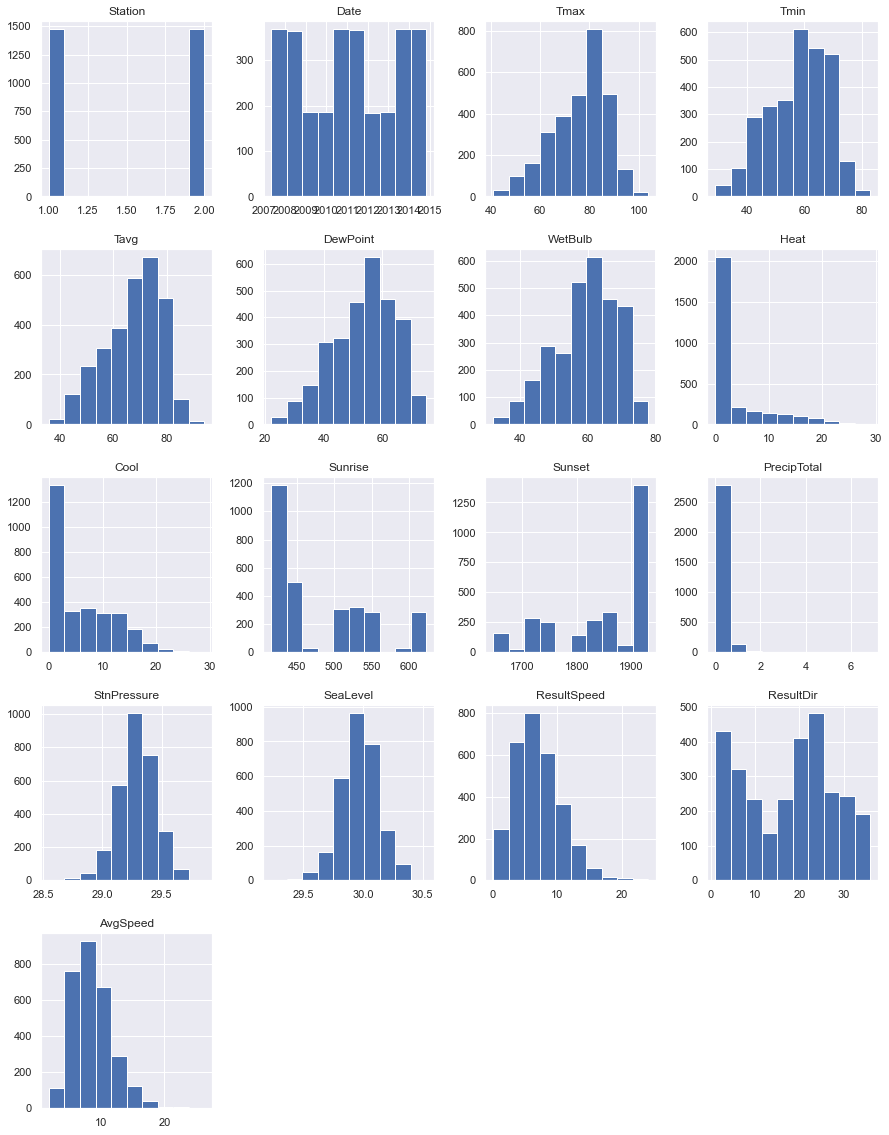

In [42]:
weather_df.hist(figsize=(15, 20))
plt.show()

## Create more features 

In [43]:
## There is good chance that Rain and tempertaure will have some delayed impact on the generation of mosquitos and 
# rsulting WNV

In [44]:
weather_df['day'] = weather_df['Date'].dt.day
weather_df['doy'] = weather_df['Date'].dt.dayofyear
weather_df['week'] = weather_df['Date'].dt.isocalendar().week
weather_df['month'] = weather_df['Date'].dt.month
weather_df['year'] = weather_df['Date'].dt.year
weather_df['yearweek'] = weather_df['year']+weather_df['week']

In [45]:
# Changed the index to date to do a time shift analysis
weather_df=weather_df.set_index('Date',drop =True)
weather_df.head()

,Station,Tmax,Tmin,Tavg,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,...,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,day,doy,week,month,year,yearweek
Date,,,,,,,,,,,,,,,,,,,,,
2007-05-01,1,83,50,67.0,51,56.0,0.0,2.0,448,1849,...,29.82,1.7,27,9.2,1,121,18,5,2007,2025
2007-05-01,2,84,52,68.0,51,57.0,0.0,3.0,448,1849,...,29.82,2.7,25,9.6,1,121,18,5,2007,2025
2007-05-02,1,59,42,51.0,42,47.0,14.0,0.0,447,1850,...,30.09,13.0,4,13.4,2,122,18,5,2007,2025
2007-05-02,2,60,43,52.0,42,47.0,13.0,0.0,447,1850,...,30.08,13.3,2,13.4,2,122,18,5,2007,2025
2007-05-03,1,66,46,56.0,40,48.0,9.0,0.0,446,1851,...,30.12,11.7,7,11.9,3,123,18,5,2007,2025


In [47]:
weather_df.to_csv('../clean_data/weather_df.csv')
train_df.to_csv('../clean_data/train_df.csv')